# House Prices: Advanced Regression Techniques

Lei Wang@Oct 2020

The task is to have the best possible prediction one can make with the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) on Kaggle.

1. Exploratory Data Analysis
    + Load data
    + Numerical and categorical features
    + Features with missing values
    + Relation of features to target (sale price)
    + Save cleaned data for further analysis


2. Data preprocessing
    + Load cleaned data
    + Numerical features: reducing skewness
    + Categorical features: converting to numerical (option A and B)
    + Merging numerical and categorical data
    + Standardization train and test data
    + Save preprocessed data for further analysis


3. Model evaluation
    + Load preprocessed data
    + Modeling (linear and nonlinear models)
    + Comparison amongst models
    + Correlation of model predictions
    + Sequential Forward Selection (SFS) model stacking
    + Final evaluation
______________________________

This notebook covers section 3. Model evaluation.

## 3. Model evaluation

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Save a dictionary into a pickle file
import pickle
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso,LassoCV
from sklearn.experimental import enable_hist_gradient_boosting #need by below
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
# helper functions below
from utils import plot_regression_results, show_CV_performance
from utils import plot_lasso_path, get_best_score

%matplotlib inline
sns.set_style("whitegrid")

# global setting
mse = 'neg_mean_squared_error'
nfold = 10 # of CV fold

### 3.1 Load preprocessed data

train: (1460, 80)
test: (1459, 79)


Text(0, 0.5, 'prices (log)')

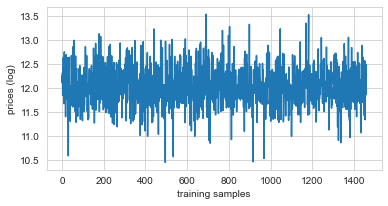

In [2]:
df_train = pd.read_csv("./data/train_3A.csv")
df_test  = pd.read_csv("./data/test_3A.csv")
# df_train = pd.read_csv("./data/train_3B.csv")
# df_test  = pd.read_csv("./data/test_3B.csv")

print('train:',df_train.shape)
print('test:',df_test.shape)

# extract the whole features for ML
X = df_train[df_train.columns[:-1]].copy()
y = df_train["SalePrice_Log"].copy()
final_test = df_test.copy() # final test X

plt.figure(figsize=(6,3))
plt.plot(y)
plt.xlabel("training samples")
plt.ylabel("prices (log)")

### 3.2 Modeling (linear and nonlinear models)
#### Linear Regression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    2.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


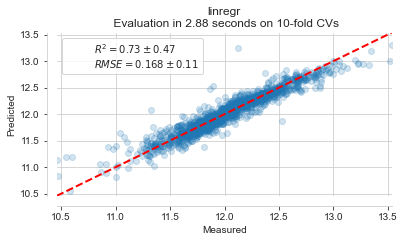

In [3]:
linregr = LinearRegression()

# show CV performance of a model, y_pred are results on test folds
y_pred_li, scores_li = show_CV_performance(X, y, linregr, nfold=nfold, title='linregr')      

#### Lasso
Lasso regression uses the L1-norm regularization, such that some coefs will be 'shrinked' to zeros.

optimal alpha: 0.004230500385146377


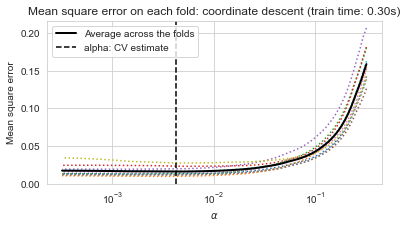

In [4]:
#%% lasso
t1 = time.time()
model = LassoCV(cv=nfold).fit(X, y)
t_lasso_cv = time.time() - t1
print('optimal alpha:', model.alpha_ ) # model.alpha_ = 0.0042

# plot the best param: alpha
plot_lasso_path(model, t_lasso_cv)

Number of non-zero coefs is  48
Number of zero coefs is  31


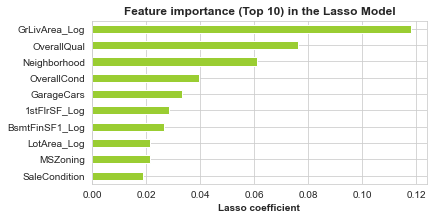

In [5]:
# important features
Lasso_coef_abs = np.abs(np.array(model.coef_))
N_nonzero = len(np.where(Lasso_coef_abs > 0)[0])
N_zero = len(np.where(Lasso_coef_abs == 0)[0])
print('Number of non-zero coefs is ', N_nonzero)
print('Number of zero coefs is ', N_zero)
  
plt.figure(figsize=(6, 3))
coefs = pd.Series(Lasso_coef_abs, index = X.columns)
imp_coefs = coefs.sort_values().tail(10)
imp_coefs.plot(kind = "barh", color='yellowgreen')
plt.xlabel("Lasso coefficient", weight='bold')
plt.title("Feature importance (Top 10) in the Lasso Model", weight='bold')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


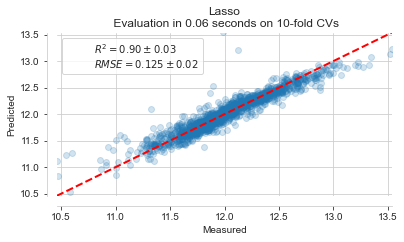

In [6]:
# show CV performance of the model using best param
model_opt = Lasso(alpha = model.alpha_)
y_pred_la, scores_la = show_CV_performance(X, y, model_opt, nfold=nfold, title='Lasso')

model_opt.fit(X, y)
y_hat_lasso = model_opt.predict(final_test) 
     

#### Ridge
Ridge regression uses the L2-norm regularization. 

The best value of Alpha:  {'alpha': 1}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


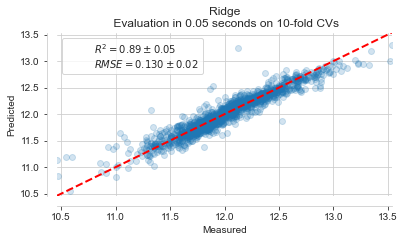

In [7]:
ridge=Ridge()
params= {'alpha':[x for x in [0.1,0.2,0.4,0.5,0.7,0.8,0.9,1]]}

ridge_gd=GridSearchCV(ridge, param_grid=params, n_jobs=-1, cv=nfold, scoring=mse)
ridge_gd.fit(X, y)
print("The best value of Alpha: ", ridge_gd.best_params_)

# show CV performance of the model using best param
model_opt = Ridge(alpha = ridge_gd.best_params_['alpha'])
y_pred_ri, scores_ri = show_CV_performance(X, y, model_opt, nfold=nfold, title='Ridge')


#### KNN

best RMSE: 0.17302760713694462
best params: {'n_neighbors': 10, 'weights': 'distance'}
best model: KNeighborsRegressor(n_neighbors=10, weights='distance')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


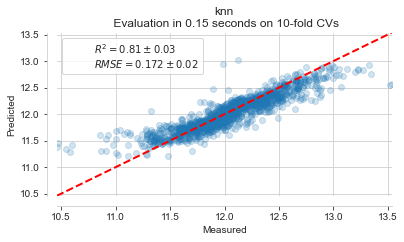

In [8]:
#%% KNN
knn = KNeighborsRegressor()
params = {'n_neighbors' : [3,5,7,10,15],    
              'weights' : ['uniform','distance']}

knn_gd=GridSearchCV(knn, param_grid=params, n_jobs=-1, cv=nfold, scoring=mse)
knn_gd.fit(X, y)
# best model: KNeighborsRegressor(n_neighbors=10, weights='distance')
best_rmse = get_best_score(knn_gd)

# show CV performance of the model using best param
model_opt = knn_gd.best_estimator_
y_pred_kn, scores_kn = show_CV_performance(X, y, model_opt, nfold=nfold, title='knn')


#### Random Forest Regressor 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished


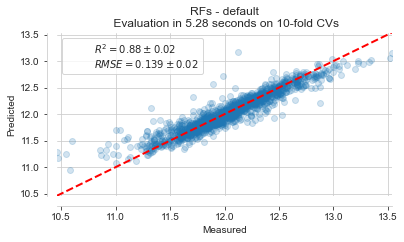

In [9]:
# The following GridSearchCV will take ~ 3 mins on a laptop with 8-CPUs 
# rf = RandomForestRegressor(random_state=2)
# params = {"n_estimators":[100,500,1000], "max_depth":[30,50,70]}

# # GridSearchCV
# start_time = time.time()
# rf_gd = GridSearchCV(rf, param_grid=params, n_jobs=-1, cv=nfold, verbose=1, scoring = mse)
# rf_gd.fit(X, y)
# elapsed_time = time.time() - start_time
# print('elapsed_time:', elapsed_time)
# best_rmse = get_best_score(rf_gd)

# # we use the best model determined by GridSearchCV
# opt_model = rf_gd.best_estimator_
# # the following works the same, but it needs hand-input the best params
# # opt_model = RandomForestRegressor(n_estimators = 1000, max_depth = 50, n_jobs = -1, random_state=2)

# # show CV performance of a model, y_pred are results on test folds
# y_pred_rf, scores_rf = show_CV_performance(X, y, opt_model, nfold=nfold, title='RFs')


# GridSearchCV above taking too much time, here just use default params instead.
model_new = RandomForestRegressor(random_state=2) # use default params
y_pred_rf, scores_rf = show_CV_performance(X, y, model_new, nfold=nfold,title='RFs - default')


#### Gradient Boosting 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.6s finished


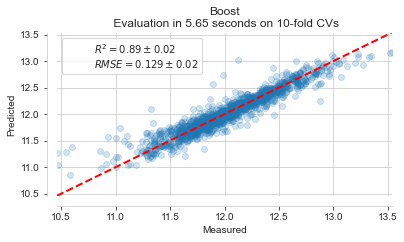

In [10]:
#%% Gradient Boosting 
Boost = HistGradientBoostingRegressor() # default, 'max_iter': 100

# show CV performance of a model
y_pred_boost, scores_boost = show_CV_performance(X, y, Boost, nfold=10, title='Boost')


#### Decision Tree

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


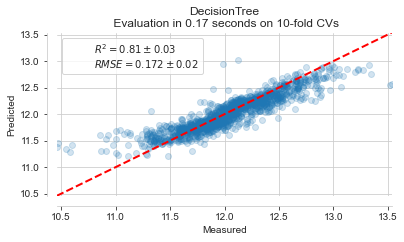

In [11]:
#%% Decision Tree
model_new = DecisionTreeRegressor(random_state=5) # use default params
y_pred_dt, scores_dt= show_CV_performance(X, y, model_opt, nfold=nfold, title='DecisionTree')


#### SVM - RBF kenal

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


elapsed_time: 8.808037757873535
best RMSE: 0.15620102578942244
best params: {'C': 1.0, 'gamma': 0.01}
best model: SVR(gamma=0.01)


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


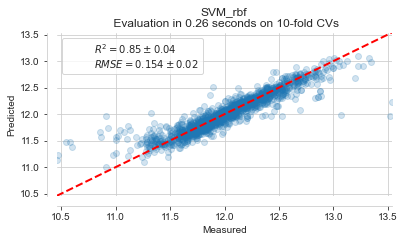

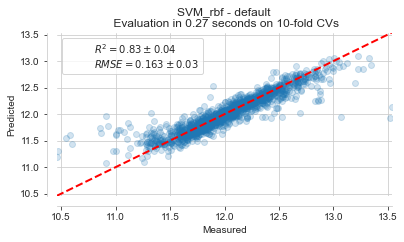

In [12]:
svr = SVR(kernel='rbf')
params = {"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)}
svr_gd = GridSearchCV(svr, param_grid=params,n_jobs=-1, cv=nfold, scoring = mse,verbose=1)
start_time = time.time()
svr_gd.fit(X, y)
elapsed_time = time.time() - start_time
print('elapsed_time:', elapsed_time)
best_rmse = get_best_score(svr_gd)
# best params: {'C': 1.0, 'gamma': 0.01}

# show CV performance of the model using best param
model_opt = svr_gd.best_estimator_
y_pred_SVM_rbf, scores_SVM_rbf = show_CV_performance(X, y, model_opt, nfold=nfold, title='SVM_rbf')

# Alternatively, using default settings
model_new  = SVR(kernel='rbf')
_, _ = show_CV_performance(X, y, model_new, nfold=nfold,title='SVM_rbf - default')


#### SVM - linear kenal

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.2s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.9s finished


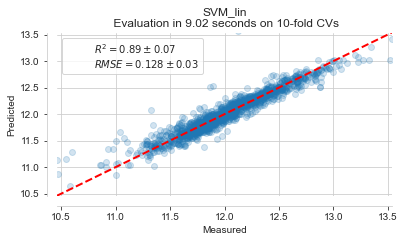

In [13]:
svr = SVR(kernel='linear')
y_pred_SVM_li, scores_SVM_li = show_CV_performance(X, y, svr, nfold=nfold, title='SVM_lin')

#### SVM - polynomial kenal

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


elapsed_time: 2.000568389892578
best RMSE: 0.2034230096702653
best params: {'degree': 3, 'gamma': 'auto'}
best model: SVR(gamma='auto', kernel='poly')


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


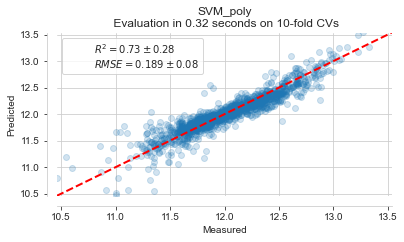

In [14]:
#%% SVM - poly kenal (degree = 3, by default)
svr = SVR(kernel='poly',degree = 3)

params = {"degree": [2,3,4], "gamma": ['scale','auto'] }
svr_gd = GridSearchCV(svr, param_grid=params,n_jobs=-1, cv=nfold, scoring = mse,verbose=1)
start_time = time.time()
svr_gd.fit(X, y)
elapsed_time = time.time() - start_time
print('elapsed_time:', elapsed_time)
best_rmse = get_best_score(svr_gd)

# show CV performance of the model using best param
model_opt = svr_gd.best_estimator_
y_pred_SVM_poly, scores_SVM_poly= show_CV_performance(X, y, model_opt, nfold=nfold, title='SVM_poly')

# Alternatively, using default settings
# svr = SVR(kernel='poly')
# y_pred_SVM_poly, scores_SVM_poly = show_CV_performance(X, y, svr, nfold=nfold, title='SVM_poly_default')



### 3.3 Comparition amongst models

Each categorical variable will be replaced by its corresponding mean value of log(saleprice). The following section demostrates this.

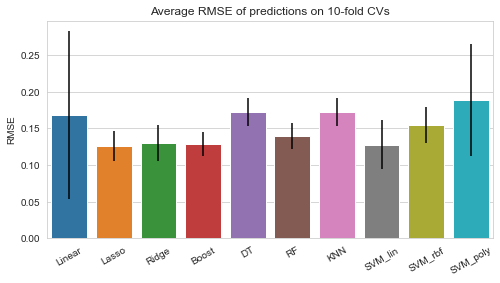

In [15]:
list_scores = [scores_li, scores_la, scores_ri, scores_boost, scores_dt,
               scores_rf, scores_kn, scores_SVM_li, scores_SVM_rbf, 
               scores_SVM_poly]
list_regressors = ['Linear', 'Lasso', 'Ridge', 'Boost', 'DT', 
                    'RF', 'KNN', 'SVM_lin', 'SVM_rbf', 'SVM_poly']

list_rmse_m = [x['RMSE_mean'] for x in list_scores]
list_rmse_std = [x['RMSE_std'] for x in list_scores]

fig, ax = plt.subplots()
fig.set_size_inches(8,4)
sns.barplot(x=list_regressors, y= list_rmse_m, yerr = list_rmse_std, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.ylabel('RMSE')
plt.title('Average RMSE of predictions on 10-fold CVs')
plt.show()
    

Convert all 43 Categorical columns to numerical.  


### 3.3 Correlation of model predictions

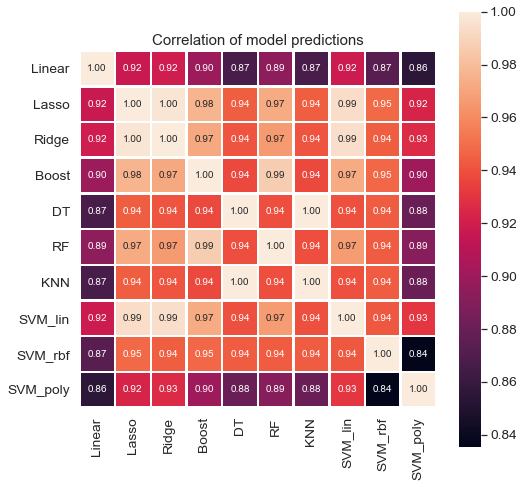

In [16]:
predictions = {'Linear': y_pred_li, 'Lasso': y_pred_la, 'Ridge': y_pred_ri,
                'Boost': y_pred_boost, 'DT': y_pred_dt, 'RF': y_pred_rf,
               'KNN': y_pred_kn, 'SVM_lin': y_pred_SVM_li,
               'SVM_rbf': y_pred_SVM_rbf,  'SVM_poly': y_pred_SVM_poly}

df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
            fmt='.2f', annot_kws={'size': 10}, 
            yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.title('Correlation of model predictions')
plt.show()

**Correlation matrix** shows that the predictions (i.e., on all CV testing sets) amongst models are different. Thus these different predictions can be 'stacked' to further improve performance. Note that Linear has highest correlation with Lasso and Ridge, thus it will not be used for model stacking due to no added value.

### 3.4 Model stacking

To improve generalizability and robustness over a single model, we employ model ensemble methods, i.e., to combine the predictions of several base estimators and make a more robust one. Compared with a simple model blending (easy to implement) method, in which coefficients are empirically chosen for each base model, model stacking (or stacking regressor) enables such coefficients computed in a secondary level model. It thus allows a better performance.

In [17]:
#%% Models with optimal params determined by 10-folds CV in the previous session
lasso_opt = Lasso(alpha = 0.00423)
ridge_opt = Ridge(alpha = 1)
knn_opt = KNeighborsRegressor(n_neighbors = 10, weights= 'distance')
rf = RandomForestRegressor(random_state=2) # use default params: N=100
boost = HistGradientBoostingRegressor() # default 'max_iter': 100
dt = DecisionTreeRegressor(random_state=5) # use default params
SVMrbf_opt = SVR(kernel='rbf', C= 1.0, gamma = 0.01)
SVMli = SVR(kernel='linear')
SVMpoly_opt = SVR(kernel='poly',degree = 3)

# models for stacking
estimators_list = [('Lasso', lasso_opt),
                    ('Ridge', ridge_opt),
                    ('KNN', knn_opt),
                    ('RF', rf),
                    ('DT', dt),
                    ('Boost', boost),
                    ('SVMrbf', SVMrbf_opt),
                    ('SVMli', SVMli),
                    ('SVMpoly', SVMpoly_opt)]

Using all available base models in a stacked model (or a blending model) is not a good idea. (This will be demonstrated in the final evaluation section). It is because that there might be ‘bad’ models that we want to exclude, and it needs to be evaluated considering the interaction amongst models. However, it is computationally expensive to evaluate all possible combinations of stacked models. Here, we use a heuristic sequential forward selection (SFS) algorithm, aiming to find a (sub)optimal solution for the model stacking.

In [18]:
def SFS_stack_models(estimators_list, X, y, nfold=10):
    """
    Sequential Forward Selection (SFS) model stacking.
    SFS starts from the 1st entry of estimators_list.
    """
    # SFS initial state
    estimators_sel = [] #seleted set
    estimators_rem = estimators_list.copy() #remaining set
    
    # SFS starts from the 1st entry of estimators_list
    estimators_sel = [estimators_rem.pop(0)]
    
    RMSE_best = []; RMSE_all_steps = []; 
    while estimators_rem:
        print('number of estimators in remaining set:', len(estimators_rem))
        # compute score of each entry in the remaining set
        RMSE_mean = []; 
        for estimator in estimators_rem:
            estimators_sel.append(estimator) # add an estimator
            
            stack = StackingRegressor(estimators = estimators_sel,
                                       # final_estimator = LassoCV()
                                        final_estimator = RidgeCV()
                                      )
            _, scores = show_CV_performance(X, y, stack,nfold=nfold,plot=False)
            RMSE_mean.append(scores['RMSE_mean'])
            
            estimators_sel.pop() # remove the added estimator
           
            
        # find the estimator that help reduce RMSE the most
        loc = RMSE_mean.index(np.min(RMSE_mean))
        print('selected estimator:', estimators_rem[loc])
        print('min RMSE on current step:', np.min(RMSE_mean))
        RMSE_best.append(np.min(RMSE_mean)) 
        RMSE_all_steps.append(RMSE_mean)
        # move it from estimators_rem to estimators_sel
        estimators_sel.append(estimators_rem.pop(loc))
          
    return  estimators_sel, RMSE_best, RMSE_all_steps 



In [19]:
#%% do SFS-model stacking  - this session will take ~ 3000 sec!      
# start_time = time.time()
# estimators_sel, RMSE_best, RMSE_all_steps = SFS_stack_models(estimators_list, 
#                                                               X, y, nfold=10)
# elapsed_time = time.time() - start_time
# print('elapsed_time:', elapsed_time)

To save time, Let's use the saved results from a pickle file, instead of runing the above session.

In [20]:
# Load the dictionary back from the pickle file.
SFS_results = pickle.load(open("SFS_Stack_ridge_results.p", "rb"))

estimators_sel = SFS_results['estimators_sel']
RMSE_best = SFS_results['RMSE_best']
RMSE_all_steps = SFS_results['RMSE_all_steps']
elapsed_time = SFS_results['elapsed_time']


Text(0.5, 1.0, 'Stacking model Sequential Forward Selection (SFS)\n Evaluation in 3021.4 seconds on all steps')

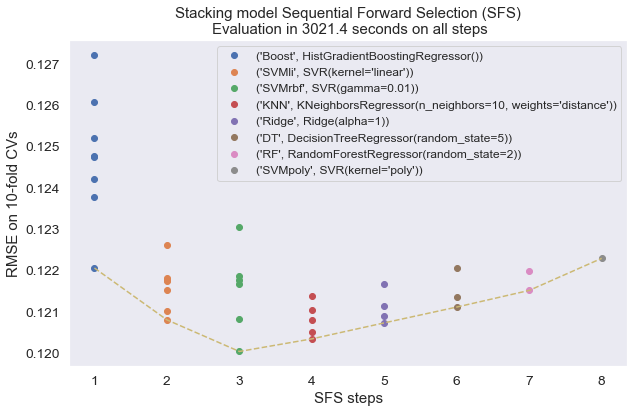

In [21]:
#%% plot SFS-stacking results
plt.figure(figsize=(10,6))
fs = 15
for i in range(len(RMSE_all_steps)): 
    plt.plot((i+1)*np.ones_like(RMSE_all_steps[i]), RMSE_all_steps[i], 'o',
             label=estimators_sel[i+1])
plt.plot(1+np.array(range(len(RMSE_best))), RMSE_best, '--')   
plt.grid() 
plt.legend(loc='best', fontsize=fs*0.8)
plt.xlabel("SFS steps", fontsize=fs)
plt.ylabel("RMSE on 10-fold CVs", fontsize=fs)
mytitle = ('Stacking model Sequential Forward Selection (SFS)'
           +'\n Evaluation in {:.1f} seconds on all steps').format(elapsed_time)
plt.title(mytitle, fontsize=fs)


The above figure shows that SFS starts from a base model ‘Lasso’, then on each step, sequentially adds another base model (the dot connected by the dashed line) that mostly improves the stacking performance (i.e., with the lowest RMSE) until that all models have been used. On step 1, the best model ‘Boost’ is added into the base models of stacking, and on step 2, ‘SVMli’, etc.
The best performance was achieved in step 3, with three base model selected: ‘Boost’, ‘SVMli’, ‘SVMrbf’.

In [22]:
# 4 base models selected for ridge-final stacking model
estimators = [estimators_list[0], estimators_list[5],
              estimators_list[6],estimators_list[7]]

stack = StackingRegressor(estimators=estimators,final_estimator = RidgeCV())
print(stack)

StackingRegressor(estimators=[('Lasso', Lasso(alpha=0.00423)),
                              ('Boost', HistGradientBoostingRegressor()),
                              ('SVMrbf', SVR(gamma=0.01)),
                              ('SVMli', SVR(kernel='linear'))],
                  final_estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ])))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    7.1s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

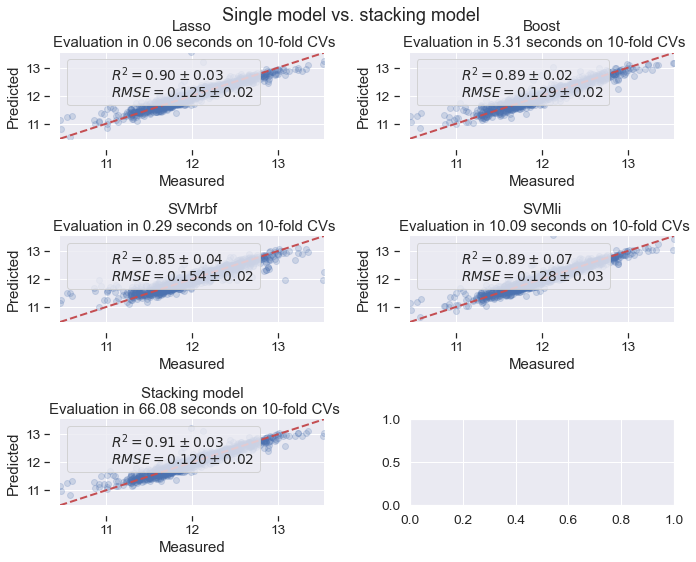

In [23]:
#%% plot single model vs stacking model
estimators_all = estimators + [('Stacking model', stack)]

# plot all in one fig
fig, axs = plt.subplots(3, 2, figsize=(10, 8))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators_all):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_squared_error'],
                           cv=nfold,
                           n_jobs=-1, verbose=1)
    elapsed_time = time.time() - start_time

    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0, cv=nfold)

    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$RMSE={:.3f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                np.mean(np.sqrt(-score['test_neg_mean_squared_error'])),
                np.std(np.sqrt(-score['test_neg_mean_squared_error']))),
        elapsed_time)

plt.suptitle('Single model vs. stacking model')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


The stacking model (last row) used the four above base models determined by the SFS-model stacking. These selected base models will ‘best’ combine the strengths of each other. As expected, the stacking model achieved the lowest RMSE of 0.120.

In [24]:
#%% predict using stacking model
stack.fit(X, y) 
y_pred_final = stack.predict(final_test)

### 3.6 Save final test result

In [25]:
#%% save final test result
sample=pd.read_csv('./data/sample_submission.csv')
save_dir = os.path.join(os.getcwd(), 'submission')

y_hat_list = [y_hat_lasso, y_pred_final] 
y_hat_name = ['singleModel_lasso', 'stack4models_ridge',] 

for y_hat, name in zip(y_hat_list, y_hat_name):
    submission=pd.DataFrame({"Id":sample['Id'],
                              "SalePrice": np.exp(y_hat)})
    submission.to_csv(os.path.join(save_dir, name +'.csv'), index = False)


End of this section.

## Reference

[scikit-learn guide: Combine predictors using stacking](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py)

[mlxtend/user_guide](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/)

[Stacking Models for Improved Predictions by By Burak Himmetoglu, UC Santa Barbara.](https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html)